# Table of Contents:
* [I. Import libraries](#I.-Import-libraries)
* [II. Load the data & some insights](#II.-Load-the-data-&-some-insights)
* [III. Part A of study graphs](#III.-Part-A-of-study-graphs)
    * [Find User's home](#Find-User's-home)
    * [Analysis of](#Analysis-of)
* [IV. Words of mouth impact](#IV.-Words-of-mouth-impact)    
    * [Get the reviewed label](#Get-the-reviewed-label)
    * [Study friends' ratings influence on mobility](#Study-friends'-ratings-influence-on-mobility)
* [V. Week Day Study](#V.-Week-Day-Study)
    

# I. Import libraries

In [16]:
import json
import math
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from bisect import bisect
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

# II. Load the data & some insights

In [2]:
# We load the 4 pre-processed datasets 
df_business = pd.read_csv('./data/df_business.csv')
df_reviews = pd.read_csv('./data/df_reviews.csv')
df_users = pd.read_csv('./data/df_user.csv')
df_selectedReviews = pd.read_csv('./data/selectedReviews.csv')

For reading purposes, the 4 datasets have the following form.

In [12]:
# Show an example
df_business.head(3)

,business_id,state,latitude,longitude,categories,stars,Travel,BusinessSupport,Home,Sport,...,RealEstate,Manufacturing,Health,Construction,Automotive,Computers,Entertainment,PersonalCare,Miscellaneous,Food
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,"['Active Life', 'Gun/Rifle Ranges', 'Guns & Am...",3.5,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,"['Health & Medical', 'Fitness & Instruction', ...",5.0,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,"['Pets', 'Pet Services', 'Pet Groomers']",5.0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [5]:
# Show an example
df_reviews.head(3)

,review_id,user_id,business_id,stars,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11


In [6]:
# Convert the string of friends to a list
df_users['friend_list'] = df_users.apply(lambda x: x.friends.split(', '), axis=1)
df_user = df_users.drop('friends', axis=1)
# Show an example
df_users.head(3)

,user_id,friends,friend_list
0,ntlvfPzc8eglqvk92iDIAw,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...","[oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfD..."
1,FOBRPlBHa3WPHFB5qYDlVg,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...","[ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOu..."
2,zZUnPeh2hEp0WydbAZEOOg,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...","[Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnP..."


In [7]:
print('There are', df_business.shape[0], 'businesses.')
print('There are', df_reviews.shape[0], 'reviews.')
print('There are', df_users.shape[0], 'users.')

There are 209393 businesses
There are 8021122 reviews
There are 1968703 users


In [7]:
# Convert date to datetime object
df_selectedReviews["date"] = pd.to_datetime(df_selectedReviews.date.values)
# Show an example
df_selectedReviews.head(3)

,Unnamed: 0,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before,square_id,dist_checkin_home,week_day
0,1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,3.5,-1,160_-413,3.490097,4
1,2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,3.5,-1,160_-413,1.435575,2
2,4,cnV5xtm6WuyaLfot9uWbDg,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3,2010-10-10 01:27:31,36.112896,-115.177637,3.5,2,160_-413,3.632600,6


# III. Part-A-of-study-graphs
explaination, purpose etc

### Find User's home

In [ ]:
# Define some constants
ONE_DEGREE_LATITIDE_TO_KM = 111
EARTH_RADIUS = 6371

# GOAL: unction used to compute the square_id given two coordinate (latitude coordinate and longitude coordinate)
# INPUT: Takes as input two float that represent the latitude and longitude (be aware that order matters!)
# OUTPUT: Returns a string that is the id of the cell in which the two coordinates are located in
# Explanations on this function are given in section I
def getSquareIdString(lat, long):
    lat_id = math.trunc(lat*ONE_DEGREE_LATITIDE_TO_KM/25.0)
    long_id = math.trunc(math.pi/180*EARTH_RADIUS*math.cos(math.radians(lat))*long/25)
    return str(lat_id)+'_'+str(long_id)

# Transform the function used to compute the square_id to a numpy usable function 
# (i.e argumennts of the function can be passed as np.array)
# This is done to improve efficiency by avoiding the use of an apply on a dataframe, which would cause a lot of overhead 
# when working with indices
vect_GetSquareIdString = np.vectorize(getSquareIdString)

In [367]:
# GOAL: compute the arc-distance between two points with format (latitude, longitude)
# INPUT: Takes two np.array where the first element is the latitude and the second is the longitude (be aware that latitude is first!)
# OUTPUT: return the distance bewteen the two given points
# NOTE: this function was copied verbatim from: 
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(x1, x2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x1[1], x1[0], x2[1], x2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [368]:
def getUserHome(df):
    # we are using the column time as a counter for the pair (user_id, square_id)
    # in the meantime, we are computing the mean latitude and longitude for each pair (user_id, square_id)
    save = df.groupby(['user_id', 'square_id']).agg({
        'date': 'count', 
        'latitude': ['mean'],
        'longitude': ['mean']
    }).reset_index()
    
    # we copy the counter of pair (user_id, square_id), the mean latitude, and mean longitude 
    # in new columns
    save['count'] = save['date']['count']
    save['latitude_home'] = save['latitude']['mean']
    save['longitude_home'] = save['longitude']['mean']

    # we drop the columns the we previously copied 
    save = save.drop([('date', 'count'), 'square_id', ('latitude', 'mean'), ('longitude', 'mean')], axis=1)
    
    # we keep only the square_id with the most count 
    save = save.loc[save.groupby('user_id')['count'].idxmax()]
    
    # we drop the column count as it will be of no use later
    save = save.drop('count', axis=1)
    return save

In [ ]:
# Compute the square_id for each user
df_selectedReviews['square_id'] = vect_GetSquareIdString(df_selectedReviews['latitude'].values, df_selectedReviews['longitude'].values)

In [ ]:
# Compute users' homes
df_homes = getUserHome(df_selectedReviews)

In [ ]:
df_homes.to_csv('./df_homes.csv',index=False)

### Analysis of

In [ ]:
# Merge review dataframe with selected users
df_complete = pd.merge(df_reviews, df_selectedUsers, left_on='user_id', right_on='user_id', how='right')
# Rename some column name for convenience
df_complete = df_complete.rename(columns={('latitude_home', ''): "latitude_home", ('longitude_home', ''): "longitude_home"})
df_business = df_business.rename(columns={"stars":"actual_stars"})

In [ ]:
# Compute the distance between user home and business location
df_complete['distance'] = df_complete.apply(lambda x: distance.cdist([(x.latitude_home, x.longitude_home)], [(x.latitude, x.longitude)], metric=haversine)[0,0], axis=1)

In [ ]:
# Add mean ratings of businesses to the main dataframe
df_complete = pd.merge(df_complete, df_business[['business_id', 'actual_stars']], left_on='business_id', right_on='business_id', how='inner')

In [ ]:
# Create the bins for the plotting
maxDistance = max(df_complete['distance'])
# Create non linear groups of distances
bins = np.geomspace(5, maxDistance, 15)
# Center the bins
binsCentered = (bins[:-1] + bins[1:])/2

#### Probability to give good review depending on distance

In [ ]:
# Group rows in dataframe by "distance"
totalReview = df_complete['review_id'].groupby(pd.cut(df_complete['distance'], bins=bins)).count()
# Good with 3 but can use 5 ----- to be modified at the end
df_goodUserreviews = df_complete[df_complete['stars_x'] >= 3]
df_badUserreviews = df_complete[df_complete['stars_x'] <= 2]

In [ ]:
# Compute good reviews and bad reviews for each group
goodUserReview = df_goodUserreviews['review_id'].groupby(pd.cut(df_goodUserreviews['distance'], bins=bins)).count()
badUserReview = df_badUserreviews['review_id'].groupby(pd.cut(df_badUserreviews['distance'], bins=bins)).count()

Plot the result.

In [ ]:
# Plot result
plt.figure(figsize=(7,6)) 
plt.plot(binsCentered,goodUserReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to Give Good Rating (stars >= 5) Depending on Distance")

##### Discussion:

--

#### Probability to go to good reviewed place

In [ ]:
# Select rows for good reviews and bad reviews
df_goodPlaceReviews = df_complete[df_complete['actual_stars'] >= 5]
df_badPlaceReviews = df_complete[df_complete['actual_stars'] <= 2]

In [ ]:
# Compute good reviews and bad reviews for each group
goodPlaceReview = df_goodPlaceReviews['review_id'].groupby(pd.cut(df_goodPlaceReviews['distance'], bins=bins)).count()
badPlaceReview = df_badPlaceReviews['review_id'].groupby(pd.cut(df_badPlaceReviews['distance'], bins=bins)).count()

Plot the result.

In [ ]:
# Plot the result
#plt.figure(figsize=(7,6)) 
plt.plot(binsCentered,goodPlaceReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
#plt.plot(binsCentered,badPlaceReview/totalReview,'ro', linestyle="-", markersize=15,label='badReview')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to go to Good Rated (stars >= 5) Place Depending on Distance")

##### Discussion:

--

#### Mean review given distance ?

In [ ]:
meanActualStars = df_complete[['review_id', 'actual_stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['actual_stars'].mean()
meanGivenStars = df_complete[['review_id', 'stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['stars'].mean()

In [ ]:
plt.plot(binsCentered,meanActualStars,'r*', linestyle="-", markersize=15,label='mean business stars')
plt.plot(binsCentered,meanGivenStars,'b*', linestyle="-", markersize=15,label='mean given stars')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower right")
plt.title("Probability to go to Good Rated (stars >= 5) Place Depending on Distance")

# IV. Words of mouth impact

In this section, we want to study friends' ratings influence on mobility with respect to traveling distances. Namely, we study whether friends' ratings can inflence on our mobility, and if yes, how?

### Get the reviewed label

To start, we distribute a `reviewed label` to each review, which is prepared for later use. The `reviewed label` is used to mark whether the business of the review have been reviewd by at least one of user's friends. If yes, whether her friend had given a good rating or not. <br>
We decide to assign 0 to `reviewed label` if no user's friend had reviewed the same business as user, 1 if at least one user's friend had reviewed the same business and gave a bad rating (i.e. rating smaller than 3) and 2 if at least one user's friend had reviewed the same business and gave a good rating (i.e. rating greater than 4).

In [ ]:
# Convert date to datatime object
df_reviews["date"] = pd.to_datetime(df_reviews.date.values)
# Rename columns
df_reviews = df_reviews.rename({"stars_x" : "rating", "stars_y" : "average_rating"},axis=1)
# Group by user_id and business_id and return the corresponding date and rating
df_reviews_groupedUser = df_reviews.groupby(["user_id","business_id"])[["date","rating"]].agg(list)
# Show an example
df_reviews_groupedUser.head()

In [ ]:
# Group by user_id and business
level_user_id = df_reviews_groupedUser.groupby(level='user_id')

# Create a dictionary of (user_id, business) → list of date and ratings of the business done by user
user_business_date_dict = {}
for idx, data in level_user_id:
    user_business_date_dict[idx] = {}
    for row_index, row in data.iterrows():
        user_business_date_dict[idx][row_index[1]] = (row.date,row.rating)

In [ ]:
def get_visit_label(user_id,business_id,date_user):
    """
        Check whether the business has been reviewed by user's friends or not 
        user_id: id of user
        business_id: id of business
        date_user: date of review
        Returns: rating of the user itself if a friend has left a good review in the same place before,
                 -1 otherwise
    """
    # Takes a row of the shape ["user_id","business_id","date"]
    
    # Get friend list of user:
    friends = friends_dict.get(user_id)
    for friend_id in friends:
        friend_dates_rating = user_business_date_dict.get(friend_id, {}).get(business_id)
        if(friend_dates_rating != None):
            for date,rating in zip(friend_dates_rating[0],friend_dates_rating[1]):
                if(date < date_user):
                    return rating
    return -1

# Vectorize the function
get_visit_label_vec = np.vectorize(get_visit_label)

In [ ]:
# Select useful columns
selected_reviews_array = np.array(df_selectedReviews[["user_id","business_id","date"]])
# Compute ratings if reviewed by a friend before
df_selectedReviews["reviewed_by_friend_before"] = get_visit_label_vec(selected_reviews_array[:,0],selected_reviews_array[:,1],selected_reviews_array[:,2])

In [ ]:
def set_label(rating):
    """
        Determine the visit label for each review
        rating: rating of business
        Return: 2 if a friend has left a good review,
                1 if a friend has left a bad review,
                0 otherwise
    """
    if rating < 0:
        return 0
    elif rating < 3:
        return 1
    elif rating > 4:
        return 2
    else :
        return 0

In [ ]:
# Assign label to each review
# 2 if a friend of user has left a good review,
# 1 if a friend of user has left a bad review,
# 0 otherwise
df_selectedReviews["reviewed_before_friend_4"] = df_selectedReviews["reviewed_by_friend_before"].apply(set_label)

In [ ]:
# Show an example
df_selectedReviews.head()

### Study friends' ratings influence on mobility

Only checkins of the business where at least one of user's friends have been a reviewed before are studied. We aim to compute the probability to move to a well reviewed business with respect to distance, and the probability to move to a badly reviewed business with respect to distance, and finally, compare the results.

In [ ]:
# Work on a copy
newframe = df_homes[['user_id']].copy()
# Create a tuple of (latitude,longitude) for each check-in
newframe['latlong'] = list(zip(df_homes['latitude_home'],df_homes['longitude_home']))
# Create the dictionary mapping from cell_id to all check-ins done in the cell
dict_user_home = newframe.groupby('user_id')['latlong'].apply(list).to_dict()

In [ ]:
# Fetch the distance from users' home and business location, computed previously
df_selectedReviews['dist_checkin_home'] = df_complete['distance'].copy()#df_selectedReviews.apply(lambda row: haversine( dict_user_home.get(row['user_id'])[0],(row['latitude'],row['longitude']) ),axis=1)

In [401]:
# List all distances between check-in location and user's home
distances = df_selectedReviews['dist_checkin_home'].values
# Prepare the distance groups for the plot
number_distance_groups = 10
# Define interval of travelling distance
interval_dist_min = 0.1
interval_dist_max = max(distances)
# Define non linear distance intervals
interval_dist = np.geomspace(interval_dist_min , interval_dist_max, number_distance_groups)

In [ ]:
# Compute id of distance group for each review
df_selectedReviews['id_groups'] = df_selectedReviews['dist_checkin_home'].apply(lambda x: bisect(interval_dist, x))
# Show an example
df_selectedReviews.head()

In [403]:
# Preapare the dataframe for word of mouth, keeping only reviews for which user's friend has reviewed the same business before
df_selectedReviews_v2 = df_selectedReviews[df_selectedReviews["reviewed_before_friend_4"] !=0]

In [404]:
def compute_fractions(df,number_distance_groups):
    """
        Compute the popability of travelling(recommended (or not) by at least one friend) as a funtion of distance travelled
        df: dataframe
        number_distance_groups: number of distance groups
        Return: porbability that user travels with/without friends' recommendation as a function of distance
    """
    # Group the dataframe by id_groups and review label
    grouped = df.groupby(['id_groups','reviewed_before_friend_4']).count()['user_id'].reset_index()
    # Count the numbers of each label in the same group
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    # Create a dictionary mapping from (group_id, label) to the number of counts
    dict_group_revlabel = grouped.groupby(['id_groups','reviewed_before_friend_4'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    # Initialize arrays
    good_reviews = []
    bad_reviews = []
    
    # For all groups
    for group_id in range(number_distance_groups):
        # Find all reviews in the group
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            # When there is no review for this group, append 0 to the fraction
            good_reviews.append(0)
            bad_reviews.append(0)
        else:
            # Count the number of recommended and not recommended reviews within the group
            group_good = (dict_group_revlabel.get((group_id,2))or 0)
            group_bad = (dict_group_revlabel.get((group_id,1))or 0)
            # Compute the porbability that user travels with/without friends' recommendation
            good_reviews.append(group_good/tot) 
            bad_reviews.append(group_bad/tot)
            
    return good_reviews,bad_reviews

In [405]:
# Compute the popability of travelling(recommended (or not) by at least one friend) as a funtion of distance travelled
good_reviews,bad_reviews = compute_fractions(df_selectedReviews_v2,number_distance_groups)

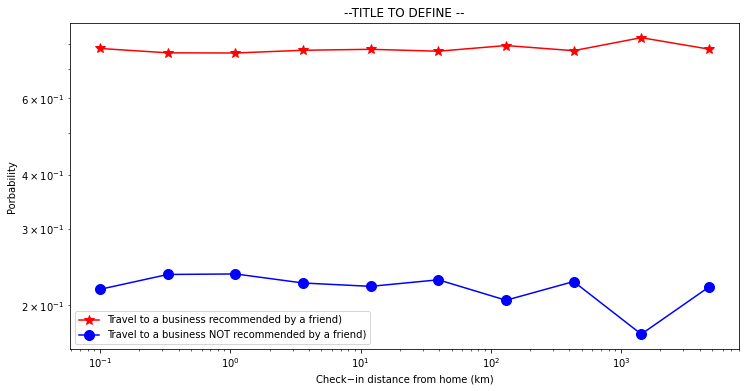

In [407]:
# Plot the result
plt.figure(figsize=(12, 6))
# What I obtain previously, with the first P_null
#plt.subplot(121)
plt.plot(interval_dist,good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
plt.plot(interval_dist,bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Porbability")
plt.xlabel("Check−in distance from home (km)")
plt.legend(loc="lower left")
plt.title("--TITLE TO DEFINE --")

plt.show()

##### Discussion:

--

# V. Week Day Study
In this section, we aim to study the pattern of humain mobility depending on week day. To do so, all reviews are grouped by week day, then the probability of travelling as a function of distance travelled is computed for each day of the week.

In [ ]:
# Apply weekday() to each date in the dataframe
df_selectedReviews["week_day"]=df_selectedReviews.date.apply(lambda x : x.weekday())

In [408]:
def compute_fractions_week(df,number_distance_groups):
    """
        For each day of the week, compute the popability of travelling as a funtion of distance travelled
        df: dataframe
        number_distance_groups: number of distance groups
        Return: porbability that user travels as a function of distance for each day
    """
    # Group the dataframe by id_groups and week day
    grouped = df.groupby(['id_groups','week_day']).count()['user_id'].reset_index()
    # Count the numbers of each label in the same group
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    # Create a dictionary mapping from (group_id, week day) to the number of counts
    dict_group_revlabel = grouped.groupby(['id_groups','week_day'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    # Initialize arrays
    mon_reviews = []
    tue_reviews = []
    wed_reviews = []
    thu_reviews = []
    fri_reviews = []
    sat_reviews = []
    sun_reviews = []
    
    # For all groups
    for group_id in range(number_distance_groups):
        # Find all reviews in the group
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            # When there is no review for this group, append 0 to the fraction
            good_reviews.append(0)
            bad_reviews.append(0)
        else:
            # Count the number of reviews for each week day within the group
            group_mon = (dict_group_revlabel.get((group_id,0))or 0)
            group_tue = (dict_group_revlabel.get((group_id,1))or 0)
            group_wed = (dict_group_revlabel.get((group_id,2))or 0)
            group_thu = (dict_group_revlabel.get((group_id,3))or 0)
            group_fri = (dict_group_revlabel.get((group_id,4))or 0)
            group_sat = (dict_group_revlabel.get((group_id,5))or 0)
            group_sun = (dict_group_revlabel.get((group_id,6))or 0)
            # Compute the porbability that user travels as a function of distance for each day
            mon_reviews.append(group_mon/tot) 
            tue_reviews.append(group_tue/tot)
            wed_reviews.append(group_wed/tot)
            thu_reviews.append(group_thu/tot)
            fri_reviews.append(group_fri/tot)
            sat_reviews.append(group_sat/tot)
            sun_reviews.append(group_sun/tot)
            
    return mon_reviews,tue_reviews,wed_reviews,thu_reviews,fri_reviews,sat_reviews,sun_reviews

In [409]:
# Compute fractions for all week days
mon_reviews,tue_reviews,wed_reviews,thu_reviews,fri_reviews,sat_reviews,sun_reviews = compute_fractions_week(df_selectedReviews_v2,number_distance_groups)

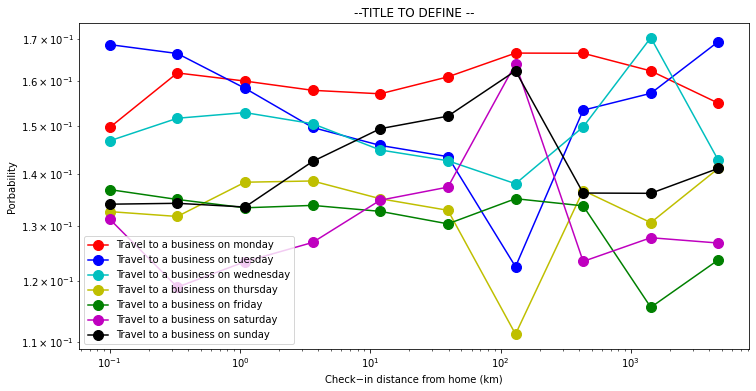

In [411]:
# Plot the result
plt.figure(figsize=(12, 6))
# What I obtain previously, with the first P_null
#plt.subplot(121)
plt.plot(interval_dist,mon_reviews,'ro-', markersize=10,label='Travel to a business on monday')
plt.plot(interval_dist,tue_reviews,'bo-', markersize=10,label='Travel to a business on tuesday')
plt.plot(interval_dist,wed_reviews,'co-', markersize=10,label='Travel to a business on wednesday')
plt.plot(interval_dist,thu_reviews,'yo-', markersize=10,label='Travel to a business on thursday')
plt.plot(interval_dist,fri_reviews,'go-', markersize=10,label='Travel to a business on friday')
plt.plot(interval_dist,sat_reviews,'mo-', markersize=10,label='Travel to a business on saturday')
plt.plot(interval_dist,sun_reviews,'ko-', markersize=10,label='Travel to a business on sunday')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Porbability")
plt.xlabel("Check−in distance from home (km)")
plt.legend(loc="lower left")
plt.title("--TITLE TO DEFINE --")

plt.show()

##### Discussion:

--

# Variant

In [412]:
mon_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 0]
tue_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 1]
wed_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 2]
thu_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 3]
fri_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 4]
sat_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 5]
sun_checkins = df_selectedReviews_v2[df_selectedReviews_v2["week_day"] == 6]

In [413]:
mon_good_reviews,mon_bad_reviews = compute_fractions(mon_checkins,number_distance_groups)
tue_good_reviews,tue_bad_reviews = compute_fractions(tue_checkins,number_distance_groups)
wed_good_reviews,wed_bad_reviews = compute_fractions(wed_checkins,number_distance_groups)
thu_good_reviews,thu_bad_reviews = compute_fractions(thu_checkins,number_distance_groups)
fri_good_reviews,fri_bad_reviews = compute_fractions(fri_checkins,number_distance_groups)
sat_good_reviews,sat_bad_reviews = compute_fractions(sat_checkins,number_distance_groups)
sun_good_reviews,sun_bad_reviews = compute_fractions(sun_checkins,number_distance_groups)

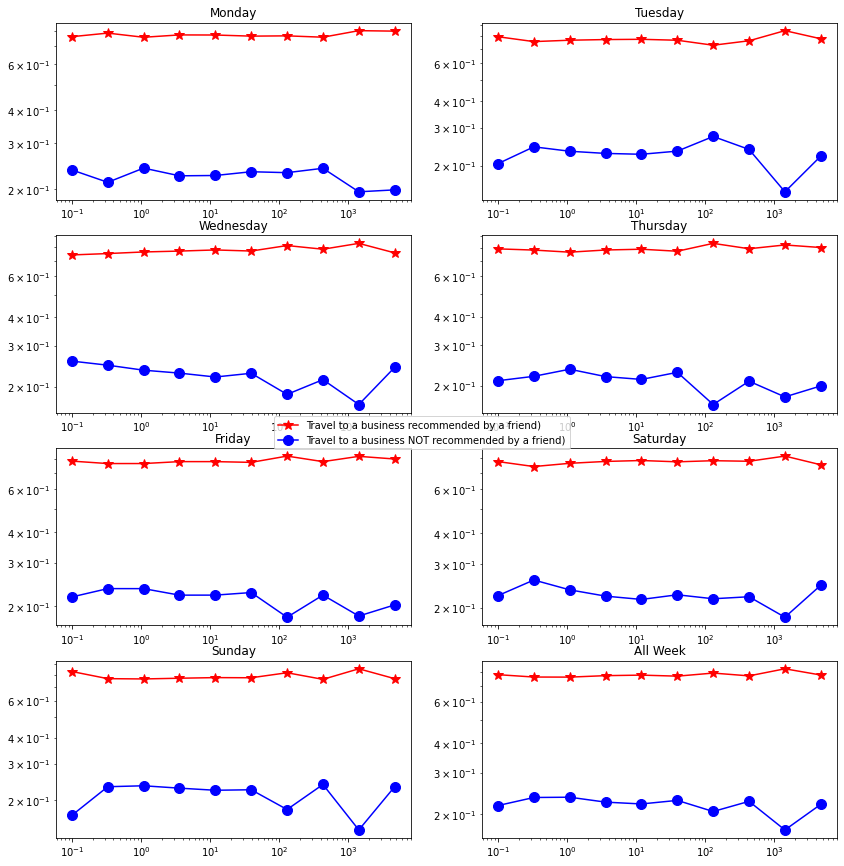

In [414]:
# Plot the result
f, ax = plt.subplots(4, 2, figsize=(14, 15))
ax[0,0].plot(interval_dist,mon_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[0,0].plot(interval_dist,mon_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_title("Monday")

ax[0,1].plot(interval_dist,tue_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[0,1].plot(interval_dist,tue_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_title("Tuesday")

ax[1,0].plot(interval_dist,wed_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[1,0].plot(interval_dist,wed_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_title("Wednesday")

ax[1,1].plot(interval_dist,thu_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[1,1].plot(interval_dist,thu_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_title("Thursday")

ax[2,0].plot(interval_dist,fri_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[2,0].plot(interval_dist,fri_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')
ax[2,0].set_title("Friday")

ax[2,1].plot(interval_dist,sat_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[2,1].plot(interval_dist,sat_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[2,1].set_xscale('log')
ax[2,1].set_yscale('log')
ax[2,1].set_title("Saturday")

ax[3,0].plot(interval_dist,sun_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[3,0].plot(interval_dist,sun_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[3,0].set_xscale('log')
ax[3,0].set_yscale('log')
ax[3,0].set_title("Sunday")

ax[3,1].plot(interval_dist,good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[3,1].plot(interval_dist,bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[3,1].set_xscale('log')
ax[3,1].set_yscale('log')
ax[3,1].set_title("All Week")


handles, labels = ax[0,0].get_legend_handles_labels()
f.legend(handles, labels, loc='center')

##### Discussion:

--

# Categories
In this section, we aim to study whether there are categories that influence more on human mobility.

In [ ]:
# Merge category masks to the selectedReview dataframe, so that we can easily get access to categories of each business
df_selectedReviews_cat = pd.merge(df_selectedReviews, df_business[["business_id"]+list(set(df_categories['category']))], left_on='business_id', right_on='business_id', how='inner')

In [ ]:
# Select only rows where business has been reviewed by at least one of user's friends before
df_selectedReviews_catv2 = df_selectedReviews_cat[df_selectedReviews_cat["reviewed_before_friend_4"] !=0]

In [ ]:
# ?
check_in_per_category_v2 = []
for cat in set(df_categories['category']):
    check_in_per_category_v2.append(df_selectedReviews_catv2[df_selectedReviews_catv2[cat] == True].drop(list(set(df_categories['category'])),axis = 1))

In [ ]:
# 
good_bad_reviews_cat_v2 = []
for df in check_in_per_category:
    good_bad_reviews_cat_v2.append(compute_fractions(df,number_distance_groups))
good_bad_reviews_cat_v2.append(compute_fractions(df_selectedReviews_catv2,number_distance_groups))

In [ ]:
# Plot the result
f, ax = plt.subplots(9, 2, figsize=(14, 20))
i = 0
for cat in set(df_categories['category']):
    ix = i%9
    iy = i%2
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v2[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v2[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
    ax[ix,iy].set_xscale('log')
    ax[ix,iy].set_yscale('log')
    ax[ix,iy].set_title(cat)
    i += 1

ax[8,1].plot(interval_dist,good_bad_reviews_cat_v2[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[8,1].plot(interval_dist,good_bad_reviews_cat_v2[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[8,1].set_xscale('log')
ax[8,1].set_yscale('log')
ax[8,1].set_title('All cat')

##### Discussion:

--

In [ ]:
# 
check_in_per_category_v1 = []
for cat in set(df_categories['category']):
    check_in_per_category_v1.append(df_selectedReviews_cat[df_selectedReviews_cat[cat] == True].drop(list(set(df_categories['category'])),axis = 1))

In [ ]:
# 
good_bad_reviews_cat_v1 = []
for df in check_in_per_category_v1:
    good_bad_reviews_cat_v1.append(compute_fractions(df,number_distance_groups))
good_bad_reviews_cat_v1.append(compute_fractions(df_selectedReviews_cat,number_distance_groups))

In [ ]:
# Plot the result
f, ax = plt.subplots(9, 2, figsize=(14, 20))
i = 0
for cat in set(df_categories['category']):
    ix = i%9
    iy = i%2
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v1[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat_v1[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
    ax[ix,iy].set_xscale('log')
    ax[ix,iy].set_yscale('log')
    ax[ix,iy].set_title(cat)
    i += 1

ax[8,1].plot(interval_dist,good_bad_reviews_cat_v1[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[8,1].plot(interval_dist,good_bad_reviews_cat_v1[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[8,1].set_xscale('log')
ax[8,1].set_yscale('log')
ax[8,1].set_title('All cat')

##### Discussion:

--